Bilayer unit domain. Sigma optimisation

In [252]:
try:
    import dolfinx
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenicsx-install-release-complex.sh" -O "/tmp/fenicsx-install.sh" && bash "/tmp/fenicsx-install.sh"
    import dolfinx

In [253]:
import matplotlib.pyplot as plt

try:
	if "science" not in plt.style.available:
		try:
			import scienceplots  # registers styles if installed
		except Exception:
			# Install SciencePlots (registers the 'science' style) and import it
			get_ipython().run_line_magic('pip', 'install -q SciencePlots')
			import scienceplots  # noqa: F401
	plt.style.use(["science", "grid"])
except Exception as e:
	# If anything fails, fall back to a commonly available style
	print("Warning: 'science' style not available. Using 'seaborn' instead. Error:", e)
	plt.style.use("seaborn")

In [254]:
import matplotlib as mpl
colors_list = [
    "#0C5DA5",  # blue
    "#00B945",  # green
    "#FF9500",  # orange
    "#FF2C00",  # red
    "#845B97",  # purple
    "#474747",  # dark gray
    "#9e9e9e",  # light gray
]

mpl.rcParams["axes.prop_cycle"] = mpl.cycler(color=colors_list)
mpl.rcParams.update({
    # Tamaño físico
    "figure.figsize": (2.9, 2.6),

    # Líneas
    "lines.linewidth": 2.0,
    "lines.markersize": 7,

    # Fuente de títulos, labels y leyendas
    "font.size": 20,
    "axes.labelsize": 20,
    "axes.titlesize": 20,
    "legend.fontsize": 18,

    # Números de los ejes un pelín más pequeños
    "xtick.labelsize": 15.5,
    "ytick.labelsize": 15.5,

    # Ejes y ticks
    "axes.linewidth": 1.4,
    "xtick.major.width": 1.4,
    "ytick.major.width": 1.4,

    # PDF limpio
    "pdf.fonttype": 42,
    "ps.fonttype": 42,
})


In [255]:
# Importing libraries
from matplotlib import ticker
import numpy as np
from mpi4py import MPI
from ufl import (
    inner,
    grad,
    conj,
    TrialFunction,
    TestFunction,
    as_matrix,
    as_vector,
    dot,
    Or,
    Measure,
    conditional,
    SpatialCoordinate,
)
from dolfinx.mesh import locate_entities_boundary, create_interval, locate_entities, create_submesh, meshtags
from dolfinx.fem import FunctionSpace, Function, functionspace, Function, dirichletbc, locate_dofs_topological, petsc, form, assemble_matrix
import basix
from petsc4py.PETSc import ScalarType
from slepc4py.SLEPc import EPS  

Domain, PML, refinement and physical configurations

In [256]:
# Define element size for the mesh refinement
h_i = [0.125/32]   
N=np.log2(0.125/h_i[0])
# Domain configuration
Lx = 1. # fluid domain length (without PML)
l_inner=Lx/2 # position of the interface between both media

# Physical configuration
rho_media_1 = 1. # kg/m^3 
vel_media_1 = 2.   # m/s
rho_media_2 = 1. # kg/m^3 
vel_media_2 = 1.   # m/s


# Define the density and velocity functions  
def rho_function(x):    
    return np.where(x[0] > l_inner, rho_media_2,rho_media_1)

def vel_function(x):    
    return np.where(x[0] > l_inner, vel_media_2,vel_media_1)

# PML configuration
pml_thickness = Lx/4

# Solver configuration
requested_eigenvalues_number = 200 # Number of eigenvalues to compute
target=-20.5j # Target for the shift-and-invert spectral transformation
degree=[2,1]  # Polynomial degree for pressure and velocity

Solver configuration and computing

In [257]:
def get_configured_problem(mesh, degrees, sigma_x, target):
    # Initialize dictionaries
    dof = {}
    solver_dict={}
    V_dict={}
    Q_dict={}

    # Define finite element spaces
    p_fe_type = basix.ufl.element(family="Lagrange", cell=mesh.basix_cell(), degree=degrees[0])
    v_fe_type = basix.ufl.element(family="DG", cell=mesh.basix_cell(), degree=degrees[1], shape=(mesh.geometry.dim,))
    FE = {"p": p_fe_type, "v": v_fe_type}

    # Create a submesh of PML associated cells
    tdim = mesh.topology.dim

    # Identify the fluid cells
    # fluid_cells = locate_entities(mesh, tdim, lambda x: x[0] <= Lx)

    # Create function spaces for mesh and submesh
    Q = functionspace(mesh,FE["p"])
    V = functionspace(mesh, FE["v"])

    # Dictionaries to store the number of dofs
    dof["p"] = Q.dofmap.index_map.size_global
    dof["v"] = V.dofmap.index_map.size_global

    # Boundary conditions application (for pressure)
    bc = []
    facets = locate_entities_boundary(mesh, 0, lambda x: np.isclose(x[0], 0.0))
    o_boundary_dofs = locate_dofs_topological(Q, 0, facets)  # the dimension is related to mesh entity where dofs are located

    # Setting to zero located dofs related to boundaries
    u_d = Function(Q)
    u_d.x.array[:] = 0.0  # Asign Dirichlet condition value
    bc.append(dirichletbc(u_d, o_boundary_dofs))

    facets = locate_entities_boundary(mesh, 0, lambda x: np.isclose(x[0], Lx+pml_thickness))
    o_boundary_dofs = locate_dofs_topological(Q, 0, facets)  # the dimension is related to mesh entity where dofs are located

    # Define the subdomains using a Python function
    TOL = 1e-6
    def pml_domain(x):
        """Returns True for points in (Lx, Lx + pml_thickness]"""
        return x[0] > Lx - TOL

    # Get topology dimension
    tdim = mesh.topology.dim

    # Locate cells in each subdomain
    pml_cells = locate_entities(mesh, tdim, pml_domain)

    # Create a meshtag to mark the subdomains
    num_cells = mesh.topology.index_map(tdim).size_local
    cell_markers = np.ones(num_cells, dtype=np.int32) # Physical domain tag=1
    cell_markers[pml_cells] = 2       # PML domain tag=2

    cell_tags = meshtags(mesh, tdim, np.arange(num_cells, dtype=np.int32), cell_markers)

    # Now you can use these tags for integration measures
    dx = Measure("dx", domain=mesh, subdomain_data=cell_tags)

    # Setting to zero located dofs related to boundaries
    u_d = Function(Q)
    u_d.x.array[:] = 0.0  # Asign Dirichlet condition value
    bc.append(dirichletbc(u_d, o_boundary_dofs))

    # Interpolates the density and velocity functions
    W = functionspace(mesh, ("DG", 0))
    rho = Function(W)
    rho.interpolate(rho_function)
    c = Function(W)
    c.interpolate(vel_function)

    # Spatial Coordinate is updated for the actual mesh
    x = SpatialCoordinate(mesh)

    # Variation formulation definition
    p = TrialFunction(Q)
    v = TrialFunction(V)
    q = TestFunction(Q)
    w = TestFunction(V)

    # Define the variational forms
    a = form(
        [
            [sigma_x(x) / (rho * c**2) * p * conj(q) * dx(2), -1 * inner(v, grad(q)) * dx],
            [inner(grad(p), w) * dx, sigma_x(x) * rho * inner(v, w) * dx(2)],
        ]
    )
    b = form(
        [
            [1.0 / (rho * c**2) * p * conj(q) * dx, None],
            [None, rho * inner(v, w) * dx],
        ]
    )
    # Assemble matrices
    A = petsc.assemble_matrix_block(a, bcs=bc)
    A.assemble()
    B = petsc.assemble_matrix_block(b, bcs=bc)
    B.assemble()

    # SLEPc solver configuration for linear eigenvalue problem (A x =\lambda x B)
    solver = EPS().create()
    solver.setOperators(-A, B)
    solver.setType("arnoldi")
    solver.setWhichEigenpairs(9)  # TARGET_IMAGINARY = 9, TARGET_MAGNITUDE = 7, TARGET_REAL = 8
    solver.setDimensions(
        requested_eigenvalues_number,
        4 * requested_eigenvalues_number,
        4 * requested_eigenvalues_number,
    )
    solver.setTolerances(1e-16, 100)
    st = solver.getST()
    st.setType("sinvert")  # Applying spectral transformation "shift and invert"
    solver.setTarget(target)
    solver.solve()
    n_eigs_converged_quadratic = solver.getConverged()

    return solver, mesh, Q, V, dof

Approx eigenvalues calculation

In [258]:
def get_closest_eigenpair(solver, omega_target, verbose=False):
    """
    Devuelve el autovalor y autovector más cercano a omega_target
    usando distancia compleja |λ - λ_target|, sin usar get_approx_eigenpair.

    Returns
    -------
    lambda_best : complex
    x_best : PETSc.Vec (copia del autovector)
    idx_best : int (índice raw en solver)
    """

    # Número de modos convergidos
    nconv = solver.getConverged()
    if nconv == 0:
        raise RuntimeError("No hay autovalores convergidos")

    # Vector temporal para extraer Eigenpairs
    vr, vi = solver.getOperators()[0].getVecs()

    best = None

    for k in range(nconv):
        lam = solver.getEigenpair(k, vr) * 1j   # igual que tú haces

        dist = abs(lam - omega_target)          # distancia COMPLEJA correcta

        if best is None or dist < best[2]:
            best = (lam, k, dist)

    lam_best, idx_best, dist_best = best

    # Obtener el autovector correspondiente
    solver.getEigenpair(idx_best, vr)  # vr = autovector del modo idx_best
    x_best = vr.copy()                 # hacemos copia

    if verbose:
        print(f"[Closest] idx={idx_best}  λ={lam_best}  dist={dist_best}")

    return lam_best, idx_best


In [259]:
def get_exact_eigenvalue(n):
    # Exact eigenvalues for the problem
    exact_physical_eigs_function= lambda n: vel_media_1 / l_inner * np.arctan(-1j * (vel_media_2 * rho_media_2) / (vel_media_1 * rho_media_1))+ n * np.pi * vel_media_1 / l_inner
    return exact_physical_eigs_function(n)

In [260]:
def get_exact_eigenpair(selected_index, Q, V, x_hat):
    exact_physical_eigs_function= lambda n: vel_media_1 / l_inner * np.arctan(-1j * (vel_media_2 * rho_media_2) / (vel_media_1 * rho_media_1))+ n * np.pi * vel_media_1 / l_inner
    w=exact_physical_eigs_function(selected_index)

    # Función de presión en el primer medio
    p_1 = lambda x: np.sin(w * x / vel_media_1)

    # Valor de p_1 en la interfaz
    p_l_inner = p_1(l_inner)

    # Función de presión en el segundo medio, continua
    p_2 = lambda x: p_l_inner * np.exp(1j * w / vel_media_2 * (x_hat(x, w) - l_inner))

    # Función de presión completa
    p = lambda x: p_1(x[0]) + (x[0] >= l_inner) * (p_2(x[0]) - p_1(x[0]))

    # Velocidad en el primer medio
    def v_1(x):
        return ((-1j/(rho_media_1*vel_media_1)) * np.cos(w * x / vel_media_1))

    # Velocidad en el segundo medio, continua con la interfaz
    def v_2(x):
        return p_1(l_inner)/(rho_media_2*vel_media_2) * np.exp(1j * w / vel_media_2 * (x_hat(x, w) - l_inner))

    # Función de velocidad completa
    v = lambda x: v_1(x[0]) + (x[0] >= l_inner) * (v_2(x[0]) - v_1(x[0]))

    p_ex = Function(Q, name="p_ex")
    p_ex.interpolate(p)

    v_ex = Function(V, name="v_ex")
    v_ex.interpolate(v)

    return [w, p_ex, v_ex]

quadratic

In [261]:
exact_omega = [None] * 100 
for j in np.arange(1, 101, 1):
    exact_omega[j-1] = get_exact_eigenvalue(j)

In [262]:
configuration= "optimal_N_5"  #"optimal_N_5" #
match configuration:
    case 'optimal_N_1':
        sigma_0_piecewise=16
        sigma_0_quadratic= 61
    case 'optimal_N_5':
        sigma_0_piecewise=35
        sigma_0_quadratic= 124


# Create mesh depending on h
mesh = create_interval(MPI.COMM_WORLD, int((Lx + pml_thickness )/ h_i[0]), [0, Lx + pml_thickness])

# Define PIECEWISE sigma function
sigma_x=lambda x: sigma_0_piecewise
# Define solver for piecewise PML
[solver_p, mesh, Q_, V_, dof_]=get_configured_problem(mesh, degree, sigma_x, target)
nconv_p = min(solver_p.getConverged(), 100)
approx=[None]*nconv_p
for j in np.arange(0, 5,1):
    # Get the approximated eigenpair
    approx[j] = get_closest_eigenpair(solver_p, exact_omega[j])[0]
    print(approx[j])
eigs_piecewise=[]
vr, vi = solver_p.getOperators()[0].getVecs()
for k in np.arange(solver_p.getConverged()):
    eigs_piecewise.append(solver_p.getEigenpair(k, vr) * 1j)

(12.5663764230924-2.1972203949968154j)
(25.13274654753107-2.1972320925299633j)
(37.69910440699745-2.1972513897031547j)
(50.26544469808485-2.197277982654238j)
(62.83176310727473-2.1973114305264927j)


In [263]:
# Define sigma function
sigma_x=lambda x: sigma_0_quadratic*(x[0]-Lx)**2/(pml_thickness**2)
# Define solver for piecewise PML
[solver_q, mesh, Q_, V_, dof_]=get_configured_problem(mesh, degree, sigma_x, target)
nconv_q = min(solver_q.getConverged(), 100)
approx=[None]*nconv_q
for j in np.arange(0, nconv_q,1):
    # Get the approximated eigenpair
    approx[j] = get_closest_eigenpair(solver_q, exact_omega[j])[0]
    print(approx[j])
eigs_quadratic=[]
vr, vi = solver_q.getOperators()[0].getVecs()
for k in np.arange(solver_q.getConverged()):
    eigs_quadratic.append(solver_q.getEigenpair(k, vr) * 1j)

(12.566371066587152-2.197224326571144j)
(25.132741337839846-2.1972241613452574j)
(37.699112772767684-2.1972238393715693j)
(50.265486108172794-2.197222559537869j)
(62.831863764046545-2.197219852561505j)
(75.39824968056257-2.197214886357931j)
(87.96464967558208-2.197206642019757j)
(100.53107183182938-2.197193887622222j)
(113.09752686550104-2.1971751657773524j)
(125.6640284928102-2.1971487776115755j)
(138.23059379255457-2.197112763988704j)
(150.7972435643481-2.197064883755222j)
(163.36400268215357-2.197002588745146j)
(175.93090044261527-2.1969229952341642j)
(188.49797090782377-2.196822851439445j)
(201.06525324212808-2.196698500652589j)
(213.63279204253837-2.1965458394797657j)
(226.20063766244144-2.19636027055742j)
(238.76884652812257-2.1961366490402114j)
(251.33748144777266-2.1958692220926377j)
(263.90661191255083-2.1955515601906863j)
(276.4763143892279-2.1951764792702746j)
(289.0466726039589-2.194735952007058j)
(301.61777781654854-2.194221006480976j)
(314.1897290846824-2.1936216099005716

In [264]:
sigma_0_singular=1

# Define PIECEWISE sigma function
sigma_x=lambda x: sigma_0_singular/(Lx+pml_thickness-x[0])

# Define solver for piecewise PML
[solver_s, mesh, Q_, V_, dof_]=get_configured_problem(mesh, degree, sigma_x, target)
nconv_s = min(solver_s.getConverged(), 100)
approx=[None]*nconv_s
for j in np.arange(0, nconv_s,1):
    # Get the approximated eigenpair
    approx[j] = get_closest_eigenpair(solver_s, exact_omega[j])[0]
    print(approx[j])
eigs_singular=[]
vr, vi = solver_s.getOperators()[0].getVecs()
for k in np.arange(solver_s.getConverged()):
    eigs_singular.append(solver_s.getEigenpair(k, vr) * 1j)

(12.566370525298462-2.1972244695601346j)
(25.132740442601214-2.197224050742873j)
(37.69910951956432-2.1972230521489986j)
(50.26547827438134-2.1972210197380955j)
(62.831848349551294-2.1972173106379445j)
(75.39822288415746-2.197211084618447j)
(87.96460688411442-2.197201291458689j)
(100.53100758998245-2.1971866529644135j)
(113.09743484189795-2.1971656381185327j)
(125.66390144133332-2.1971364294511817j)
(138.2304235095036-2.1970968783581126j)
(150.7970208425314-2.197044446734516j)
(163.36371726400617-2.196976131924214j)
(175.93054097632282-2.1968883714440293j)
(188.4975249134724-2.1967769237164254j)
(201.06470709987545-2.1966367207434123j)
(213.6321310226767-2.196461688668916j)
(226.19984602891373-2.1962445329067113j)
(238.7679077644185-2.1959764861874014j)
(251.33637867852724-2.1956470216700232j)
(263.90532862761745-2.1952435402603068j)
(276.4748356206194-2.194751053671686j)
(289.0449867599802-2.1941519052416996j)
(301.6158794385025-2.193425602739138j)
(314.18762285047455-2.19254888544433

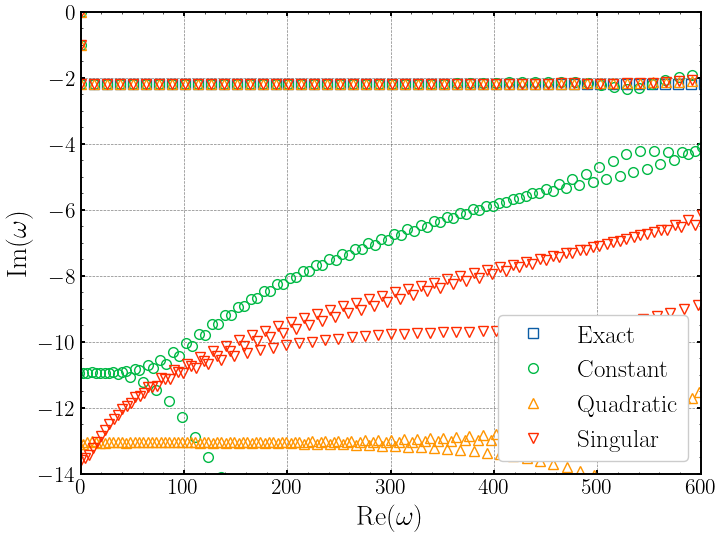

In [265]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


fig, ax = plt.subplots(figsize=(8,6))

# Try to use the 'science' style; if it's not available, attempt to install SciencePlots,
# otherwise fall back to a safe default style.


# Plote principal
ax.plot(np.real(exact_omega), np.imag(exact_omega), 's', markerfacecolor='none', color=colors_list[0], label='Exact')
ax.plot(np.real(eigs_piecewise), np.imag(eigs_piecewise), 'o', markerfacecolor='none', color=colors_list[1], label='Constant')
ax.plot(np.real(eigs_quadratic), np.imag(eigs_quadratic), marker='^',linestyle='none', markerfacecolor='none', color=colors_list[2], label='Quadratic')
ax.plot(np.real(eigs_singular), np.imag(eigs_singular), 'v', markerfacecolor='none', color=colors_list[3], label='Singular')


ax.set_xlabel(r'$\mathrm{Re}(\omega)$')
ax.set_ylabel(r'$\mathrm{Im}(\omega)$')
ax.grid(True)
# ax.set_title(f'Spectrum for N={N}')
plt.xlim([0,600])
plt.ylim([-14, 0])


# plt.ylim([-3.5, -1.5])
# Sen rectángulo de zoom
ax.legend(loc='lower right')
# plt.tight_layout()
plt.savefig(f"1D_bicapa_espectro_N_{N}_{configuration}.pdf", bbox_inches="tight")
plt.show()


In [266]:
# import numpy as np
# import matplotlib.pyplot as plt
# from mpl_toolkits.axes_grid1.inset_locator import inset_axes


# fig, ax = plt.subplots(figsize=(8,6))

# # Try to use the 'science' style; if it's not available, attempt to install SciencePlots,
# # otherwise fall back to a safe default style.


# # Plote principal
# ax.plot(np.real(exact_omega), np.imag(exact_omega), 's', markerfacecolor='none', color=colors_list[0], label='exact')
# ax.plot(np.real(eigs_piecewise), np.imag(eigs_piecewise), 'x', color=colors_list[1], label='Constant')
# ax.plot(np.real(eigs_quadratic), np.imag(eigs_quadratic), marker='+',linestyle='none', markerfacecolor='none', color=colors_list[0], label='quadratic')
# ax.plot(np.real(eigs_singular), np.imag(eigs_singular), '.', color=colors_list[3], label='singular')


# ax.set_xlabel(r'$\mathrm{Re}(\omega)$')
# ax.set_ylabel(r'$\mathrm{Im}(\omega)$')
# ax.grid(True)
# # ax.set_title(f'Spectrum for N={N}')
# plt.xlim([0,70])
# plt.ylim([-14, -1])

# # Crear inset (zoom) máis abaixo e á dereita
# axins = inset_axes(ax, width="50%", height="50%", 
#                    bbox_to_anchor=(0.38, 0.1, 0.6, 0.6),  # x0 máis á dereita, y0 máis abaixo
#                    bbox_transform=ax.transAxes)

# axins.plot(np.real(eigs_piecewise), np.imag(eigs_piecewise), 'x', color=colors[1])
# axins.plot(np.real(eigs_quadratic), np.imag(eigs_quadratic),  marker='+',linestyle='none', markerfacecolor='none', color=colors[0])
# axins.plot(np.real(eigs_singular), np.imag(eigs_singular), '.', color=colors[3])
# axins.plot(np.real(exact_omega), np.imag(exact_omega), 's', markerfacecolor='none', color=colors[2])
# axins.grid(True)


# # Limitar zoom manualmente
# axins.set_xlim(20, 60)
# axins.set_ylim(-2.2, -2.195)

# # plt.ylim([-2.3, -2.1])
# # Sen rectángulo de zoom
# ax.legend(loc='lower right')
# plt.tight_layout()
# # plt.title(f'Spectrum for N={N}')
# plt.savefig(f"1D_bicapa_espectro_N_{N}_{case}_zoom.pdf", bbox_inches="tight")
# plt.show()
